# 1.Import Data

In [1]:
import numpy as np
import pickle
import sklearn
import tensorflow as tf
from tqdm import tqdm

In [2]:
y_name={
    "y_train":"train_y",
    "y_test":"test_y"
}

In [3]:
def open_pkl(file_name):
    all_data=dict()
    for each_key in file_name.keys():
        name = file_name[each_key]
        pickle_file = open('DataSet\\'+name+".pkl",mode="rb")
        data = pickle.load(pickle_file)
        pickle_file.close()
        all_data[each_key]=data
    return all_data

In [4]:
y_data = open_pkl(y_name)
y_train = y_data["y_train"]
y_test = y_data["y_test"]

In [5]:
y_train

array([0, 3, 0, ..., 0, 0, 0])

In [6]:
# data with suffix "_word2vec" means this data is transformed based on pretrained word2vec lexicon.
# data with suffix "_glove" means this data is transformed based on pretrained glove lexicon.
file_name0={
    #"train0":"vec_train_a_no_cor_word2vec",# data without correction of misspell and shorthand and emoji, emoticon
    #"train1":"vec_train_a_no_emo_word2vec",# data without emoji and emoticon
    "train2":"vec_train_a_emo_word2vec",# data with emoji and emoticon
    #"train3":"vec_train_a_no_cor_glove",# data without correction of misspell and shorthand and emoji, emoticon
    #"train4":"vec_train_a_no_emo_glove",# data without emoji and emoticon
    "train5":"vec_train_a_emo_glove"# data with emoji and emoticon
    }
file_name1={
    #"test0":"vec_test_a_no_cor_word2vec",
    #"test1":"vec_test_a_no_emo_word2vec",
    "test2":"vec_test_a_emo_word2vec",
    #"test3":"vec_test_a_no_cor_glove",
    #"test4":"vec_test_a_no_emo_glove",
    "test5":"vec_test_a_emo_glove"
}

In [7]:
#import data
def open_pkl_data(file_name):
    all_data=dict()
    for each_key in file_name.keys():
        name = file_name[each_key]
        pickle_file = open('DataSet\\'+name+".pkl",mode="rb")
        data = pickle.load(pickle_file)
        pickle_file.close()
        all_data[each_key]=np.array(data)
    return all_data

In [8]:
train_data = open_pkl_data(file_name0)
test_data = open_pkl_data(file_name1)

In [9]:
train_data["train2"][:1]

array([array([[ 0.24609375,  0.02563477,  0.03881836, ..., -0.12695312,
         0.04223633, -0.16503906],
       [ 0.16992188, -0.19042969,  0.23828125, ..., -0.21777344,
         0.09765625, -0.26171875],
       [ 0.21777344,  0.07714844,  0.03833008, ..., -0.54296875,
         0.35546875, -0.0246582 ],
       ...,
       [ 0.02114868, -0.21972656,  0.515625  , ...,  0.03369141,
         0.4921875 ,  0.32080078],
       [ 0.5830078 ,  0.29882812,  0.2475586 , ..., -0.5214844 ,
        -0.47753906,  0.5390625 ],
       [ 0.4453125 ,  0.45703125,  0.20800781, ..., -0.4658203 ,
        -0.8847656 , -0.45703125]], dtype=float32)], dtype=object)

# 2.Preprocessing for padding the sentence
- because each sentence is different on length, we need to extend those shorter sentence to the same length for further analysis

In [10]:
# increase the length of each text in each row till it matches the max length of all the texts
def getlen_max(input_data):
    'function for estimating the max length of text in data'
    max_no = 0
    for text in input_data:
        num_word = len(text)
        if max_no <= num_word:
            max_no = num_word

    return max_no

In [11]:
def compare_length(input_dict1,input_dict2):
    max_no = 0
    for key in input_dict1.keys():
        comparison = getlen_max(input_dict1[key])
        if max_no < comparison:
            max_no = comparison
    for key in input_dict2.keys():
        comparison = getlen_max(input_dict2[key])
        if max_no < comparison:
            max_no = comparison
    return max_no

In [12]:
# coz it doesn't matter how long we set the sentence, so I use the max length directly regardless of from which data resource
len_max = compare_length(train_data,test_data)
print(len_max)

173


In [13]:
# because the data is too big, the pad_sequences just turn all data into 0. so I choose to build the function by myself
from tensorflow.keras.preprocessing.sequence import pad_sequences
def extension_sentence(input_data,len_max):
    output_data=dict()
    for key in input_data.keys():
        output_data[key] = pad_sequences(input_data[key],maxlen=len_max,padding="post")
    
    return output_data

In [14]:
def extend_text(input_data, len_max,padding="post",dimension=300):
    content=list()
    if padding == "post":
        for text in tqdm(input_data):
            add_no = len_max - len(text)
            x = np.zeros((add_no,dimension))
            new_text = np.vstack((text,x))#padding is post
            content.append(new_text)
            
    elif padding == "pre":
        for text in tqdm(input_data):
            add_no = len_max - len(text)
            x = np.zeros((add_no,dimension))
            new_text = np.vstack((x,text))#padding is pre
            content.append(new_text)

    content = np.array(content)
    return content

In [15]:
test = [[[1,2,3],[3,4,5]],[[1,2,3],[4,5,6]]]
test = np.array(test)
test = extend_text(test,len_max,dimension=3)
print(test)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]

[[[1. 2. 3.]
  [3. 4. 5.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[1. 2. 3.]
  [4. 5. 6.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


In [16]:
# because of memory error, I have to disclose the for loop of all dict. Instead padding the text of data one by one
X_train=dict()
X_test=dict()

In [17]:
key_name = "train2"
X_train[key_name] = extend_text(train_data[key_name],len_max)

100%|██████████████████████████████████████████████████████████████████████████| 30160/30160 [00:06<00:00, 4775.78it/s]


In [18]:
key_name = "train5"
X_train[key_name] = extend_text(train_data[key_name],len_max)

100%|██████████████████████████████████████████████████████████████████████████| 30160/30160 [00:06<00:00, 4690.58it/s]


In [19]:
key_name = "test2"
X_test[key_name] = extend_text(test_data[key_name],len_max)

100%|████████████████████████████████████████████████████████████████████████████| 5509/5509 [00:04<00:00, 1308.56it/s]


In [20]:
key_name = "test5"
X_test[key_name] = extend_text(test_data[key_name],len_max)

100%|████████████████████████████████████████████████████████████████████████████| 5509/5509 [00:02<00:00, 1915.97it/s]


# 3. Preprocessing of y
- if we use 1 hot representation, we must change y again
- but it only depends on with loss function we apply on our model

In [21]:
# in order to plot ROC curve and calculate AUC, I need to turn y label into 1 hot representation.
# transfer y label from {class:[0,1,2,3]} into {class: [1,0,0,0], [0,1,0,0],[0,0,1,0],[0,0,0,1]}
emotion = {"others":0,"happy":1,"sad":2,"angry":3}
y_test1hot = tf.keras.utils.to_categorical(y_test,num_classes=4)

# 4.build 1D CNN Model
## 4.1.buidling model

In [22]:
# firstly we need to make sure our input share the same format
input_shape = X_train["train2"][0].shape
print(input_shape) # this means 300 length vectors with 162 timesteps

(173, 300)


In [23]:
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [24]:
def model_build():
    # initialize CNN model
    model = tf.keras.Sequential()
    
    # add 1st convolution layer. here particularly need input_shape
    model.add(Conv1D(filters=150, kernel_size=2, activation="relu",padding="same", input_shape=input_shape))
    
    # add 2nd convolution layer with different kernal_size 3
    model.add(Conv1D(filters=150, kernel_size=3, activation="relu",padding="same"))
    
    # add 3rd convolution layer with different kernal_size 4
    model.add(Conv1D(filters=150, kernel_size=4, activation="relu",padding="same"))
    # add 1st max pooling, because sentences share different length, so I only count max value from each feature map.
    # therefore ,finally when I get to the ann input layer, I can have fixed dimensionality of input data.
    model.add(MaxPooling1D(pool_size=len_max,padding="valid"))
    model.add(Dropout(0.2))
    
    # add flattern
    model.add(Flatten())
    
    # from now on it's ANN analysis layer, we set enough neurons for full connection, add 1st hidden layer
    # because sentences are built based on fluent thinking style, so I use rectifier as activation function to avoid gradual change
    model.add(Dense(units=100, activation='relu'))
    
    # here I add 2nd hidden layer
    model.add(Dense(units=100, activation='relu'))
    
    # add output layer, since the category of label is "happy, sad, angry, others", i use 4 neurons as output outcome
    # it's because I also need the possibility for the prediction, so I set sigmoid as activation function
    model.add(Dense(units=4, activation='sigmoid'))
    
    return model

## 4.2.Compilation

In [25]:
cnn_model = model_build()
# we use stochastic gradient descent as our optimizer, cross entropy as our loss function
cnn_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 173, 150)          90150     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 173, 150)          67650     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 173, 150)          90150     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 150)            0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 150)            0         
_________________________________________________________________
flatten (Flatten)            (None, 150)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

## 4.3. Save Model Function

In [5]:
# global parameter
modelname="CNN"

In [27]:
def save_model(name,model,modelname):
    model_json=model.to_json()
    # specialize model to json
    name_path = "DataSet\\{a}_{b}".format(a=modelname,b=name)
    with open(name_path+".json","w") as json_file:
        json_file.write(model_json)
        
    # sepcialize weights to HDF5
    model.save_weights(name_path+".h5")
    print("Save model to DataSet archive successfully")

## 5. Training the CNN on the Training set

In [28]:
history=dict() # to store the history of the model training
epochs = 100
batch = 100
vali_split=0.1
# though validation_data is not used in propagation, the model will be gradually familier with validation data. There can be information leak.
# therefore, normally use validation_split for testing model to avoid overfitting

In [29]:
key_name="train2"
key_name2="test2"
history[key_name]=cnn_model.fit(x = X_train[key_name],y=y_train,validation_split=0.1, epochs =epochs, batch_size=batch)
save_model(key_name,cnn_model,modelname)

Epoch 1/100
272/272 [==============================] - 91s 336ms/step - loss: 0.5411 - accuracy: 0.7829 - val_loss: 0.3566 - val_accuracy: 0.8770
Epoch 2/100
272/272 [==============================] - 84s 310ms/step - loss: 0.2954 - accuracy: 0.9001 - val_loss: 0.3119 - val_accuracy: 0.8886
Epoch 3/100
272/272 [==============================] - 85s 314ms/step - loss: 0.2443 - accuracy: 0.9158 - val_loss: 0.2947 - val_accuracy: 0.9029
Epoch 4/100
272/272 [==============================] - 86s 315ms/step - loss: 0.2096 - accuracy: 0.9271 - val_loss: 0.3112 - val_accuracy: 0.8979
Epoch 5/100
272/272 [==============================] - 88s 325ms/step - loss: 0.1890 - accuracy: 0.9355 - val_loss: 0.2928 - val_accuracy: 0.9045
Epoch 6/100
272/272 [==============================] - 92s 338ms/step - loss: 0.1603 - accuracy: 0.9458 - val_loss: 0.3051 - val_accuracy: 0.9022
Epoch 7/100
272/272 [==============================] - 90s 331ms/step - loss: 0.1432 - accuracy: 0.9504 - val_loss: 0.3112 -

Epoch 57/100
272/272 [==============================] - 93s 341ms/step - loss: 0.0251 - accuracy: 0.9910 - val_loss: 0.6183 - val_accuracy: 0.8989
Epoch 58/100
272/272 [==============================] - 95s 350ms/step - loss: 0.0185 - accuracy: 0.9931 - val_loss: 0.7331 - val_accuracy: 0.9042
Epoch 59/100
272/272 [==============================] - 96s 354ms/step - loss: 0.0188 - accuracy: 0.9932 - val_loss: 0.6350 - val_accuracy: 0.8922
Epoch 60/100
272/272 [==============================] - 95s 348ms/step - loss: 0.0167 - accuracy: 0.9935 - val_loss: 0.6306 - val_accuracy: 0.8952
Epoch 61/100
272/272 [==============================] - 93s 343ms/step - loss: 0.0174 - accuracy: 0.9927 - val_loss: 0.6662 - val_accuracy: 0.9002
Epoch 62/100
272/272 [==============================] - 96s 354ms/step - loss: 0.0165 - accuracy: 0.9936 - val_loss: 0.6973 - val_accuracy: 0.9035
Epoch 63/100
272/272 [==============================] - 92s 339ms/step - loss: 0.0204 - accuracy: 0.9921 - val_loss: 0

In [30]:
key_name="train5"
key_name2="test5"
history[key_name]=cnn_model.fit(x = X_train[key_name],y=y_train,validation_split=0.1, epochs =epochs, batch_size=batch)
save_model(key_name,cnn_model,modelname)

Epoch 1/100
272/272 [==============================] - 95s 349ms/step - loss: 0.7471 - accuracy: 0.7427 - val_loss: 0.4165 - val_accuracy: 0.8564
Epoch 2/100
272/272 [==============================] - 96s 353ms/step - loss: 0.3536 - accuracy: 0.8782 - val_loss: 0.3522 - val_accuracy: 0.8767
Epoch 3/100
272/272 [==============================] - 94s 346ms/step - loss: 0.2865 - accuracy: 0.9007 - val_loss: 0.3365 - val_accuracy: 0.8823
Epoch 4/100
272/272 [==============================] - 92s 338ms/step - loss: 0.2386 - accuracy: 0.9168 - val_loss: 0.3250 - val_accuracy: 0.8926
Epoch 5/100
272/272 [==============================] - 98s 359ms/step - loss: 0.2103 - accuracy: 0.9265 - val_loss: 0.3202 - val_accuracy: 0.8969
Epoch 6/100
272/272 [==============================] - 91s 336ms/step - loss: 0.1867 - accuracy: 0.9342 - val_loss: 0.3413 - val_accuracy: 0.8876
Epoch 7/100
272/272 [==============================] - 97s 355ms/step - loss: 0.1702 - accuracy: 0.9417 - val_loss: 0.3740 -

Epoch 57/100
272/272 [==============================] - 95s 350ms/step - loss: 0.0215 - accuracy: 0.9920 - val_loss: 0.7531 - val_accuracy: 0.9009
Epoch 58/100
272/272 [==============================] - 92s 340ms/step - loss: 0.0242 - accuracy: 0.9924 - val_loss: 0.6945 - val_accuracy: 0.8959
Epoch 59/100
272/272 [==============================] - 97s 357ms/step - loss: 0.0255 - accuracy: 0.9903 - val_loss: 0.7182 - val_accuracy: 0.9029
Epoch 60/100
272/272 [==============================] - 93s 343ms/step - loss: 0.0231 - accuracy: 0.9915 - val_loss: 0.7072 - val_accuracy: 0.8962
Epoch 61/100
272/272 [==============================] - 95s 349ms/step - loss: 0.0277 - accuracy: 0.9893 - val_loss: 0.7155 - val_accuracy: 0.8969
Epoch 62/100
272/272 [==============================] - 95s 350ms/step - loss: 0.0264 - accuracy: 0.9897 - val_loss: 0.7366 - val_accuracy: 0.9022
Epoch 63/100
272/272 [==============================] - 94s 344ms/step - loss: 0.0255 - accuracy: 0.9911 - val_loss: 0

# 6. Load Model

In [2]:
model_names = {
    #"train0":"train0",
    #"train1":"train1",
    "train2":"train2",
    #"train3":"train3",
    #"train4":"train4",
    "train5":"train5",
}

In [3]:
def load_model(names,modelname):
    models = dict()
    for key in names.keys():
        # load json file
        load_path = "DataSet\\{a}_{b}".format(a=modelname,b=names[key])
        json_file = open(load_path+".json",'r')
        model_json = json_file.read()
        json_file.close()
        model = tf.keras.models.model_from_json(model_json)
        # load weights and assign them to the model
        model.load_weights(load_path+".h5")
        print("loaded {a} model successfully".format(a=names[key]))
        models[key]=model
    
    return models

In [6]:
models_dict = load_model(model_names,modelname)

loaded train2 model successfully
loaded train5 model successfully


# 7.Prediction

In [7]:
# function for getting prediction
def get_prediction(classifiers, test_dict):
    y_pred_dict= dict()
    list1 = list(classifiers.keys())
    list2 = list(test_dict.keys())
    length = len(list1)
    
    for i in tqdm(range(length)):
        y_pred_dict[list2[i]]=classifiers[list1[i]].predict(test_dict[list2[i]])
        
    return y_pred_dict

In [8]:
y_scores = get_prediction(models_dict,X_test)

NameError: name 'X_test' is not defined

In [36]:
# to process the possibilities into category
def get_result(y_score):
    y_result=list()
    for each_pred in y_score:
        max_no=0
        pos =0
        for i in range(4):
            if max_no < each_pred[i]:
                max_no = each_pred[i]
                pos = i
        y_result.append(pos)
    
    y_result = np.array(y_result)
    return y_result

def get_result_all(y_scores):
    y_preds=dict()
    for key in y_scores.keys():
        y_preds[key]=get_result(y_scores[key])
    return y_preds

In [37]:
y_preds = get_result_all(y_scores)

In [38]:
# function for saving the predictions and scores
def save_prediction(name,data):
    pickle_file = open('Prediction\\'+name+".pkl",mode='wb')
    pickle.dump(data,pickle_file)
    pickle_file.close()

In [39]:
path_preds="{0}_preds".format(modelname)
path_scores="{0}_scores".format(modelname)
save_prediction(path_preds,y_preds)
save_prediction(path_scores,y_scores)

# 8.Evaluation
## 8.1.plot learning curve

In [40]:
import matplotlib.pyplot as plt

def plot_learningCurve(singlehistory,epochs,modelname,dataname):
    epoch_range = range(1, epochs +1)
    plt.figure()
    plt.plot(epoch_range,singlehistory.history['accuracy'],color='b',label='accuracy')
    plt.plot(epoch_range,singlehistory.history['val_accuracy'],color='r',label='validation accuracy')
    plt.xlim([0.0,epochs+1.0])
    plt.ylim([0.0,1.2])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('History of {a} Model Accuracy on data {b}'.format(a=modelname,b=dataname))
    plt.legend(loc="lower right")
    plt.savefig("Pictures\\{a}\\History of {b} Model Accuracy on data {c}.png".format(a=modelname,b=modelname,c=dataname))
    plt.show()
    
    plt.figure()
    plt.plot(epoch_range,singlehistory.history['loss'],color='b',label='loss')
    plt.plot(epoch_range,singlehistory.history['val_loss'],color='r',label='validation loss')
    plt.xlim([0.0,epochs+1.0])
    plt.ylim([0.0,1.2])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('History of {a} Model Loss on data {b}'.format(a=modelname,b=dataname))
    plt.legend(loc="upper left")
    plt.savefig("Pictures\\{a}\\History of {b} Model Loss on data {c}.png".format(a=modelname,b=modelname,c=dataname))
    plt.show()

In [41]:
def plot_learningCurve_all(history,epochs,modelname):
    for key in history.keys():
        plot_learningCurve(history[key],epochs,modelname,key)

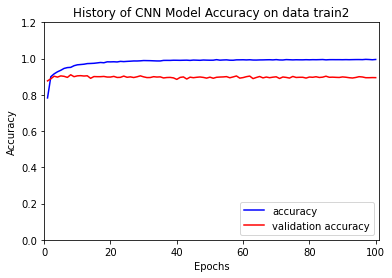

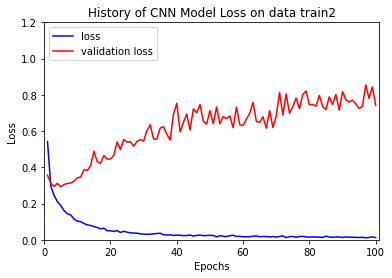

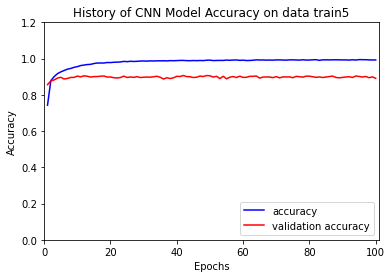

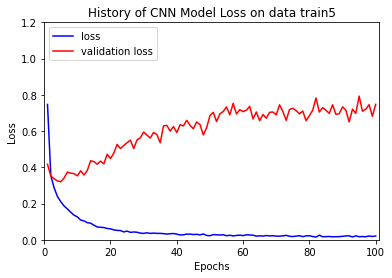

In [42]:
plot_learningCurve_all(history,epochs,modelname)

In [43]:
history['train5'].history['accuracy']

[0.7427055835723877,
 0.8782419562339783,
 0.9007146954536438,
 0.9168140292167664,
 0.926539957523346,
 0.9341659545898438,
 0.9416813850402832,
 0.9456601738929749,
 0.9518862366676331,
 0.9556071162223816,
 0.9615753293037415,
 0.9642646908760071,
 0.9670645594596863,
 0.968243420124054,
 0.9727748036384583,
 0.975537896156311,
 0.9756484031677246,
 0.9757589101791382,
 0.9783377647399902,
 0.9780430197715759,
 0.9798482060432434,
 0.9803639650344849,
 0.9812849760055542,
 0.9846374988555908,
 0.9831269979476929,
 0.9852269291877747,
 0.9841585755348206,
 0.9850059151649475,
 0.9864795207977295,
 0.9869216084480286,
 0.9860742688179016,
 0.98743736743927,
 0.9868847727775574,
 0.9877689480781555,
 0.9876584410667419,
 0.988100528717041,
 0.9872900247573853,
 0.9888004660606384,
 0.9883952140808105,
 0.9889847040176392,
 0.9900162220001221,
 0.9899057149887085,
 0.988726794719696,
 0.9885057210922241,
 0.9893530607223511,
 0.988726794719696,
 0.9896109700202942,
 0.9890215396881104,


## 8.2. Evaluation: confusion matrix, accuracy, precision, recall, F1 score

In [44]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
# print evaluation result
def get_evaluation(y_test,y_pred,oneX_test, model):
    ev = dict()
    ev["confusion_matrix"]=confusion_matrix(y_test,y_pred)
    ev["accuracy"] = accuracy_score(y_test,y_pred)
    ev["precision_macro"]=precision_score(y_test,y_pred,average="macro")
    ev["precision_micro"]=precision_score(y_test,y_pred,average="micro")
    ev["precision_weighted"]=precision_score(y_test,y_pred,average="weighted")
    ev["recall_macro"]=recall_score(y_test,y_pred,average="macro")
    ev["recall_micro"]=recall_score(y_test,y_pred,average="micro")
    ev["recall_weighted"]=recall_score(y_test,y_pred,average="weighted")
    ev["F1_score_macro"]=f1_score(y_test,y_pred,average="macro")
    ev["F1_score_micro"]=f1_score(y_test,y_pred,average="micro")
    ev["F1_score_weighted"]=f1_score(y_test,y_pred,average="weighted")
    
    for key in ev.keys():
        if key !="confusion_matrix":
            print("{a} is: {b}".format(a=key, b=ev[key]))
        else:
            print(ev[key])
    
    # and also the basic evaluation from keras
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    eval_ = model.evaluate(oneX_test,y_test)
    print("Loss: {0:.7}".format(eval_[0]))
    print("Accuracy: {0:.2%}".format(eval_[1]))
    
    return ev

In [45]:
#"macro": "Calculate metrics for each label, and find their unweighted mean. ",
#"micro": "Calculate metrics globally by counting the total true positives, false negatives and false positives."
#"weighted":"Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). "

def get_evaluation_all(y_test, y_pred_dict, X_test,models):
    list_test = list(y_pred_dict.keys())
    list_train = list(models.keys())
    length = len(list_test)
    for i in tqdm(range(length)):
        print("evaluation on data {0}".format(list_test[i]))
        get_evaluation(y_test, y_pred_dict[list_test[i]],X_test[list_test[i]],models[list_train[i]])

        print("***************************************")
        

In [46]:
get_evaluation_all(y_test,y_preds,X_test,models_dict)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

evaluation on data test2
[[4107  186  115  269]
 [  68  211    1    4]
 [  27    3  210   10]
 [  30    2    6  260]]
accuracy is: 0.8691232528589581
precision_macro is: 0.6516725607919894
precision_micro is: 0.8691232528589581
precision_weighted is: 0.9055621835650565
recall_macro is: 0.8333919931113603
recall_micro is: 0.8691232528589581
recall_weighted is: 0.8691232528589581
F1_score_macro is: 0.719277592041573
F1_score_micro is: 0.8691232528589581
F1_score_weighted is: 0.8806529860349136
173/173 [==============================] - 7s 43ms/step - loss: 0.9542 - accuracy: 0.8691


 50%|██████████████████████████████████████████                                          | 1/2 [00:08<00:08,  8.84s/it]

Loss: 0.9541627
Accuracy: 86.91%
***************************************
evaluation on data test5
[[4178   97  118  284]
 [  82  193    4    5]
 [  25    0  207   18]
 [  29    0    6  263]]
accuracy is: 0.8787438736612816
precision_macro is: 0.6783264828346222
precision_micro is: 0.8787438736612816
precision_weighted is: 0.9095188023851363
recall_macro is: 0.8208588690549491
recall_micro is: 0.8787438736612816
recall_weighted is: 0.8787438736612816
F1_score_macro is: 0.728882694240243
F1_score_micro is: 0.8787438736612816
F1_score_weighted is: 0.8885772838611712
173/173 [==============================] - 7s 40ms/step - loss: 0.8566 - accuracy: 0.8787


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:16<00:00,  8.46s/it]

Loss: 0.8566426
Accuracy: 87.87%
***************************************


## 8.2. Evaluation: ROC curve, AUC

In [47]:
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

In [48]:
def compute_roc_auc(y_test1hot, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_class = 4
    
    # compute roc curve and auc based on each label
    for i in range(n_class):
        fpr[i],tpr[i],_ = roc_curve(y_test1hot[:,i],y_score[:,i])
        roc_auc[i] = auc(fpr[i],tpr[i])
    
    # compute roc curve and auc based on average type = "micro"
    fpr["micro"],tpr["micro"],_=roc_curve(y_test1hot.ravel(),y_score.ravel())
    roc_auc["micro"]=auc(fpr["micro"],tpr["micro"])
    
    # compute roc curve and auc based on average type = "macro"
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_class)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_class):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        
    # Finally average it and compute AUC
    mean_tpr = mean_tpr/n_class
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"],tpr["macro"])
    
    return fpr, tpr, roc_auc

In [49]:
def compute_roc_auc_all(y_test1hot, y_scores):
    fprs=dict()
    tprs=dict()
    roc_aucs=dict()
    for key in tqdm(y_scores.keys()):
        fprs[key],tprs[key],roc_aucs[key]=compute_roc_auc(y_test1hot,y_scores[key])
    
    return fprs,tprs,roc_aucs

In [50]:
def plot_roc(fpr, tpr, roc_auc, dataname,modelname,choose = "all"):
    n_class=4
    
    # make variable choose as command for choosing which curve to show
    # below it's the explaination of choose
    ex_choose = {
        "all": "show all curves",
        "macro": "only show macro curve",
        "micro": "only show micro curve",
        "label": "only show curves of labels"
        }
    
    colors = ["y", "g","cornflowerblue","r"]
    label_name = ["others", "happy","sad","angry"]
    plt.figure()
    
    if (choose !="macro") and (choose !="label"):
        # draw the line of micro-average ROC curve
        plt.plot(fpr["micro"],tpr["micro"],
                 label="micro-average ROC (AUC: {0:0.2f})".format(roc_auc["micro"]),
                 color = 'deeppink',linestyle=':',lw=4)
    
    if (choose !="micro") and (choose !="label"):
        # draw the line of macro-average ROC curve
        plt.plot(fpr["macro"],tpr["macro"],
                 label="macro-average ROC (AUC: {0:0.2f})".format(roc_auc["macro"]),
                 color = 'navy',linestyle=':',lw=4)
        
    if (choose !="macro") and (choose !="micro"):    
        # draw line of each label
        for i in range(n_class):
            plt.plot(fpr[i],tpr[i],color=colors[i],lw=2,
                     label="ROC of class {0} {1} (AUC: {2:0.2f})"
                     "".format(i,label_name[i],roc_auc[i]))
    
    plt.plot([0,1],[0,1],linestyle="--",color='k',lw=2)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve on data {0} by model {1}'.format(dataname,modelname))
    
    plt.legend(loc="lower right")
    plt.savefig("Pictures\\{a}\\SingleData\\ROC Curve by model {b}_{c} on data {d}.png".format(a=modelname,d=dataname,b=modelname,c=choose))
    plt.show()
    

In [51]:
fprs,tprs,roc_aucs=compute_roc_auc_all(y_test1hot, y_scores)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 32.04it/s]


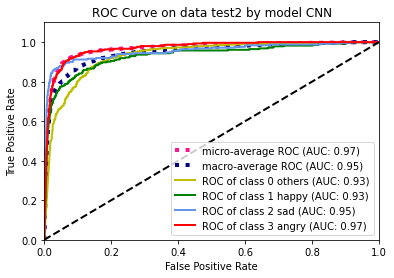

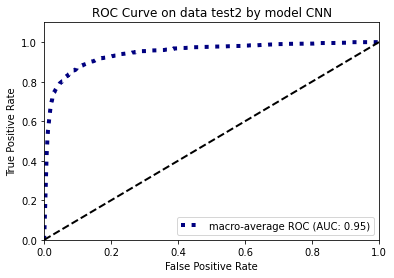

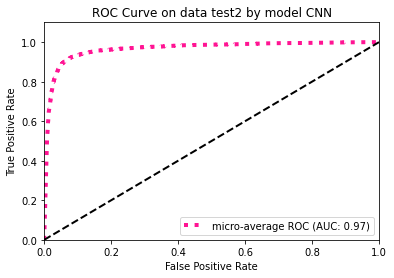

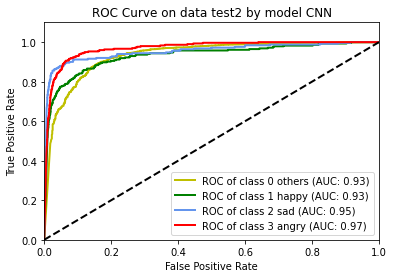

In [52]:
key_name = "test2"
fpr = fprs[key_name]
tpr = tprs[key_name]
roc_auc = roc_aucs[key_name]
dataname=key_name
plot_roc(fpr, tpr, roc_auc, dataname,modelname,choose = "all")
plot_roc(fpr, tpr, roc_auc, dataname,modelname,choose = "macro")
plot_roc(fpr, tpr, roc_auc, dataname,modelname,choose = "micro")
plot_roc(fpr, tpr, roc_auc, dataname,modelname,choose = "label")

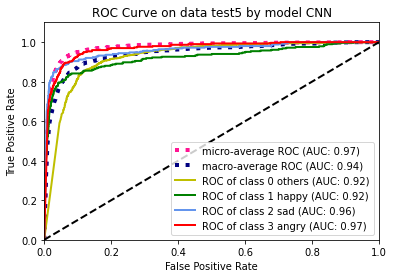

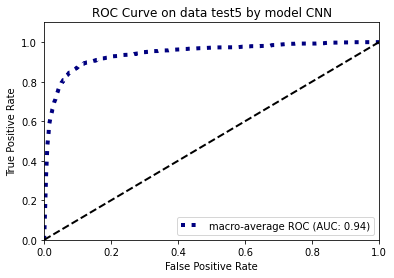

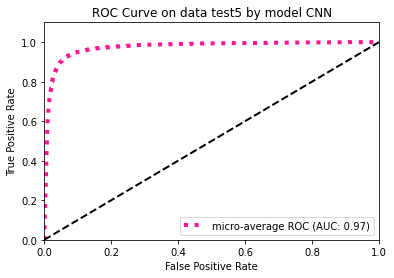

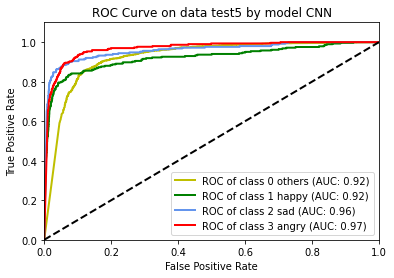

In [53]:
key_name = "test5"
fpr = fprs[key_name]
tpr = tprs[key_name]
roc_auc = roc_aucs[key_name]
dataname=key_name
plot_roc(fpr, tpr, roc_auc, dataname,modelname,choose = "all")
plot_roc(fpr, tpr, roc_auc, dataname,modelname,choose = "macro")
plot_roc(fpr, tpr, roc_auc, dataname,modelname,choose = "micro")
plot_roc(fpr, tpr, roc_auc, dataname,modelname,choose = "label")

## 8.3.Evaluation: P-R Curve, average precision

In [54]:
def compute_p_r_curve(y_test1hot, y_score):
    n_class = 4
    precision = dict()
    recall = dict()
    average_precision =dict()
    
    # compute P-R curve on each label
    for i in range(n_class):
        precision[i],recall[i], _ = precision_recall_curve(y_test1hot[:,i],y_score[:,i])
        average_precision[i] = average_precision_score(y_test1hot[:,i],y_score[:,i])
        
    # compute P-R curve with average = "micro"
    precision["micro"],recall["micro"],_=precision_recall_curve(y_test1hot.ravel(),y_score.ravel())
    average_precision["micro"]=average_precision_score(y_test1hot,y_score,average="micro")
    
    return precision,recall,average_precision

In [55]:
def compute_p_r_curve_all(y_test1hot, y_scores):
    recalls=dict()
    precisions=dict()
    average_precisions=dict()
    for key in y_scores.keys():
        recalls[key],precisions[key],average_precisions[key]=compute_p_r_curve(y_test1hot,y_scores[key])
    
    return recalls,precisions,average_precisions
    

In [56]:
def plot_pr(recall, precision, average_precision, dataname,modelname,choose = "all"):
    n_class=4
    
    # make variable choose as command for choosing which curve to show
    # below it's the explaination of choose
    ex_choose = {
        "all": "show all curves",
        "micro": "only show micro curve",
        "label": "only show curves of labels"
        }
    
    colors = ["y", "g","cornflowerblue","r"]
    label_name = ["others", "happy","sad","angry"]
    plt.figure()
    
    if choose !="label":
        # draw the line of micro-average ROC curve
        plt.plot(recall["micro"],precision["micro"],
                 label="micro-average P-R curve (average precision: {0:0.2f})".format(average_precision["micro"]),
                 color = 'deeppink',linestyle=':',lw=4)
    
        
    if choose !="micro":    
        # draw line of each label
        for i in range(n_class):
            plt.plot(recall[i],precision[i],color=colors[i],lw=2,
                     label="P-R curve of class {0} {1} (average precision: {2:0.2f})"
                     "".format(i,label_name[i],average_precision[i]))
    
    plt.plot([0,1],[1,0],linestyle="--",color='k',lw=2)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.1])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('P-R Curve on data {0} by model {1}'.format(dataname,modelname))
    
    plt.legend(loc="lower left")
    plt.savefig("Pictures\\{a}\\SingleData\\P-R Curve by model {b}_{c} on data {d}.png".format(a=modelname,d=dataname,b=modelname,c=choose))
    plt.show()
    

In [57]:
recalls,precisions,average_precisions = compute_p_r_curve_all(y_test1hot, y_scores)

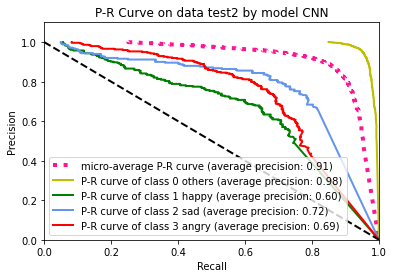

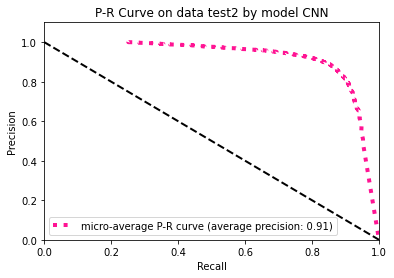

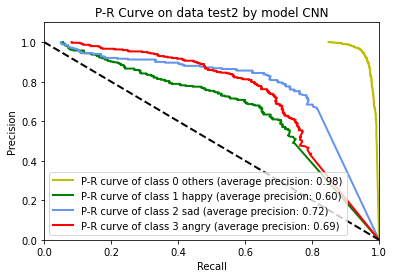

In [58]:
key_name="test2"
recall=recalls[key_name]
precision=precisions[key_name]
average_precision=average_precisions[key_name]
dataname=key_name
plot_pr(recall, precision, average_precision, dataname,modelname,choose = "all")
plot_pr(recall, precision, average_precision, dataname,modelname,choose = "micro")
plot_pr(recall, precision, average_precision, dataname,modelname,choose = "label")

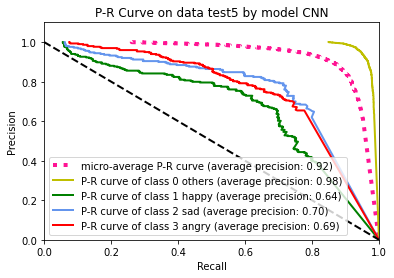

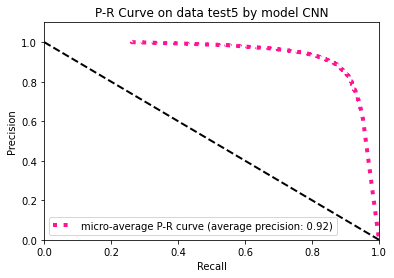

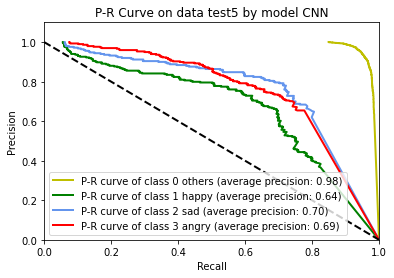

In [59]:
key_name="test5"
recall=recalls[key_name]
precision=precisions[key_name]
average_precision=average_precisions[key_name]
dataname=key_name
plot_pr(recall, precision, average_precision, dataname,modelname,choose = "all")
plot_pr(recall, precision, average_precision, dataname,modelname,choose = "micro")
plot_pr(recall, precision, average_precision, dataname,modelname,choose = "label")